Tuto du site

https://www.tensorflow.org/tutorials/images/classification?hl=fr

Importer TensorFlow et d'autres bibliothèques

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


**Téléchargez et explorez le jeu de données**

Ce didacticiel utilise un jeu de données d'environ 3 700 photos de fleurs. Le jeu de données contient cinq sous-répertoires, un par classe :

flower_photo/  
  daisy/
  
  dandelion/
  
  roses/
  
  sunflowers/
  
  tulips/

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 1s 0us/step


Après le téléchargement, vous devriez maintenant avoir une copie de l'ensemble de données disponible. Il y a 3 670 images au total :

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Voici quelques roses :

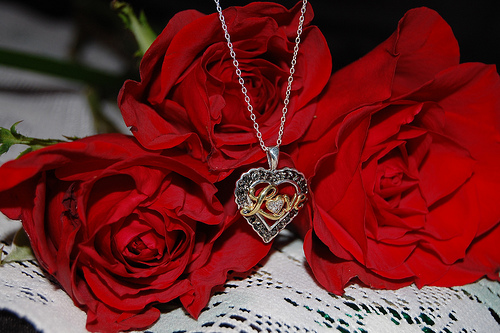

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

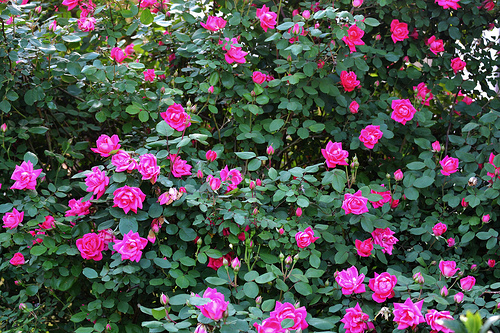

In [ ]:
PIL.Image.open(str(roses[1]))

Et quelques tulipes :

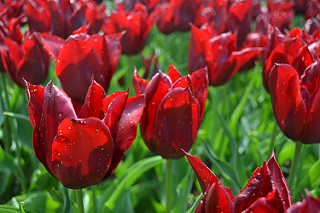

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

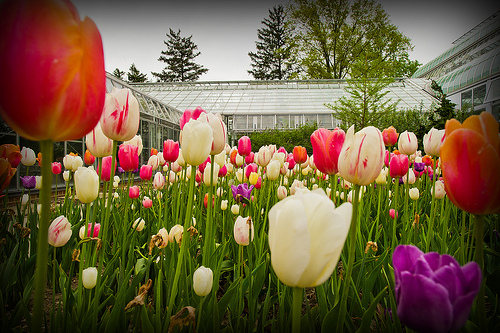

In [ ]:
PIL.Image.open(str(tulips[1]))

**Charger des données à l'aide d'un utilitaire Keras**

Chargeons ces images hors disque à l'aide de l'utilitaire utile tf.keras.utils.image_dataset_from_directory . Cela vous mènera d'un répertoire d'images sur disque à un tf.data.Dataset en seulement quelques lignes de code. Si vous le souhaitez, vous pouvez également écrire votre propre code de chargement de données à partir de rien en consultant le didacticiel Charger et prétraiter les images .

**Créer un ensemble de données**

Définissez quelques paramètres pour le chargeur :

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Il est recommandé d'utiliser une division de validation lors du développement de votre modèle. Utilisons 80% des images pour la formation et 20% pour la validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Vous pouvez trouver les noms de classe dans l'attribut class_names sur ces ensembles de données. Ceux-ci correspondent aux noms des répertoires par ordre alphabétique.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**Visualisez les données**

Voici les neuf premières images de l'ensemble de données d'entraînement :

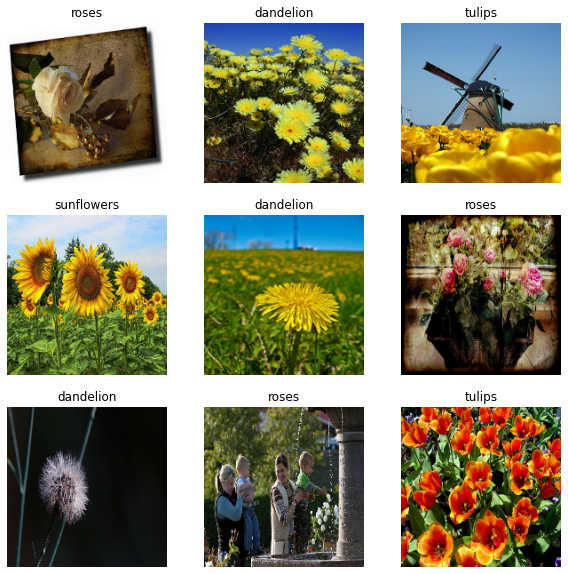

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Vous entraînerez un modèle à l'aide de ces ensembles de données en les transmettant à Model.fit dans un instant. Si vous le souhaitez, vous pouvez également parcourir manuellement l'ensemble de données et récupérer des lots d'images :

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


L' image_batch est un tenseur de la forme (32, 180, 180, 3) . Il s'agit d'un lot de 32 images de forme 180x180x3 (la dernière dimension fait référence aux canaux de couleur RVB). Le label_batch est un tenseur de la forme (32,) , ce sont des labels correspondants aux 32 images.

Vous pouvez appeler .numpy() sur les tenseurs image_batch et labels_batch pour les convertir en numpy.ndarray .

**Configurer l'ensemble de données pour les performances**

Assurons-nous d'utiliser la prélecture tamponnée afin que vous puissiez récupérer des données à partir du disque sans que les E/S ne deviennent bloquantes. Voici deux méthodes importantes que vous devez utiliser lors du chargement des données :

* Dataset.cache conserve les images en mémoire après leur chargement hors disque au cours de la première époque. Cela garantira que l'ensemble de données ne devienne pas un goulot d'étranglement lors de la formation de votre modèle. Si votre jeu de données est trop volumineux pour tenir en mémoire, vous pouvez également utiliser cette méthode pour créer un cache sur disque performant.

* Dataset.prefetch chevauche le prétraitement des données et l'exécution du modèle pendant la formation.

Les lecteurs intéressés peuvent en savoir plus sur les deux méthodes, ainsi que sur la mise en cache des données sur le disque dans la section Prélecture du guide Meilleures performances avec l'API tf.data .

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardiser les données**

Les valeurs des canaux RVB sont dans la plage [0, 255] . Ce n'est pas idéal pour un réseau neuronal ; en général, vous devriez chercher à rendre vos valeurs d'entrée petites.

Ici, vous allez normaliser les valeurs pour qu'elles soient dans la plage [0, 1] en utilisant tf.keras.layers.Rescaling :

In [ ]:
normalization_layer = layers.Rescaling(1./255)

Il existe deux façons d'utiliser cette couche. Vous pouvez l'appliquer au jeu de données en appelant Dataset.map :

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 1.0


Ou, vous pouvez inclure la couche dans la définition de votre modèle, ce qui peut simplifier le déploiement. Utilisons ici la deuxième approche.

**Créer le modèle**

Le modèle séquentiel se compose de trois blocs de convolution ( tf.keras.layers.Conv2D ) avec une couche de regroupement maximum ( tf.keras.layers.MaxPooling2D ) dans chacun d'eux. Il y a une couche entièrement connectée ( tf.keras.layers.Dense ) avec 128 unités dessus qui est activée par une fonction d'activation ReLU ( 'relu' ). Ce modèle n'a pas été réglé pour une grande précision. L'objectif de ce didacticiel est de montrer une approche standard.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compiler le modèle

Pour ce didacticiel, choisissez l'optimiseur tf.keras.optimizers.Adam et la fonction de perte tf.keras.losses.SparseCategoricalCrossentropy . Pour afficher la précision de la formation et de la validation pour chaque époque de formation, transmettez l'argument metrics à Model.compile .

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Résumé du modèle

Affichez toutes les couches du réseau à l'aide de la méthode Model.summary du modèle :

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

**Former le modèle**

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 120s 1s/step - loss: 1.4785 - accuracy: 0.3753 - val_loss: 1.1814 - val_accuracy: 0.5014
Epoch 2/10
92/92 [==============================] - 117s 1s/step - loss: 1.0440 - accuracy: 0.5858 - val_loss: 1.0205 - val_accuracy: 0.6008
Epoch 3/10
92/92 [==============================] - 116s 1s/step - loss: 0.8743 - accuracy: 0.6519 - val_loss: 0.9653 - val_accuracy: 0.6281
Epoch 4/10
92/92 [==============================] - 119s 1s/step - loss: 0.7159 - accuracy: 0.7333 - val_loss: 0.9060 - val_accuracy: 0.6485
Epoch 5/10
92/92 [==============================] - 115s 1s/step - loss: 0.5325 - accuracy: 0.7943 - val_loss: 0.9774 - val_accuracy: 0.6172
Epoch 6/10
92/92 [==============================] - 114s 1s/step - loss: 0.3258 - accuracy: 0.8934 - val_loss: 1.0143 - val_accuracy: 0.6322
Epoch 7/10
92/92 [==============================] - 109s 1s/step - loss: 0.2075 - accuracy: 0.9332 - val_loss: 1.5069 - val_accuracy: 0.6063
Epoch 8/10
92

**Visualisez les résultats de l'entraînement**

Créez des tracés de perte et de précision sur les ensembles d'entraînement et de validation :

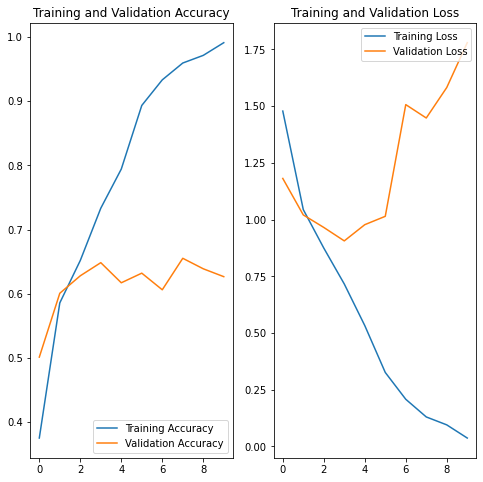

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Les graphiques montrent que la précision de la formation et la précision de la validation sont très éloignées, et le modèle n'a atteint qu'une précision d'environ 60 % sur l'ensemble de validation.

Examinons ce qui n'a pas fonctionné et essayons d'augmenter les performances globales du modèle.

**Sur-ajustement**

Dans les graphiques ci-dessus, la précision de la formation augmente de manière linéaire au fil du temps, tandis que la précision de la validation stagne à environ 60 % dans le processus de formation. De plus, la différence de précision entre la précision de la formation et celle de la validation est perceptible, signe de surapprentissage .

Lorsqu'il existe un petit nombre d'exemples d'apprentissage, le modèle apprend parfois des bruits ou des détails indésirables des exemples d'apprentissage, à tel point que cela a un impact négatif sur les performances du modèle sur les nouveaux exemples. Ce phénomène est connu sous le nom de surajustement. Cela signifie que le modèle aura du mal à généraliser sur un nouvel ensemble de données.

Il existe plusieurs façons de lutter contre le surentraînement dans le processus de formation. Dans ce didacticiel, vous utiliserez l'augmentation des données et ajouterez Dropout à votre modèle.

**Augmentation des données**

Le surajustement se produit généralement lorsqu'il y a un petit nombre d'exemples de formation. L'augmentation des données consiste à générer des données d'entraînement supplémentaires à partir de vos exemples existants en les augmentant à l'aide de transformations aléatoires qui produisent des images d'apparence crédible. Cela permet d'exposer le modèle à davantage d'aspects des données et de mieux généraliser.

Vous implémenterez l'augmentation des données à l'aide des couches de prétraitement Keras suivantes : tf.keras.layers.RandomFlip , tf.keras.layers.RandomRotation et tf.keras.layers.RandomZoom . Celles-ci peuvent être incluses dans votre modèle comme d'autres couches et exécutées sur le GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualisons à quoi ressemblent quelques exemples augmentés en appliquant plusieurs fois l'augmentation de données à la même image :

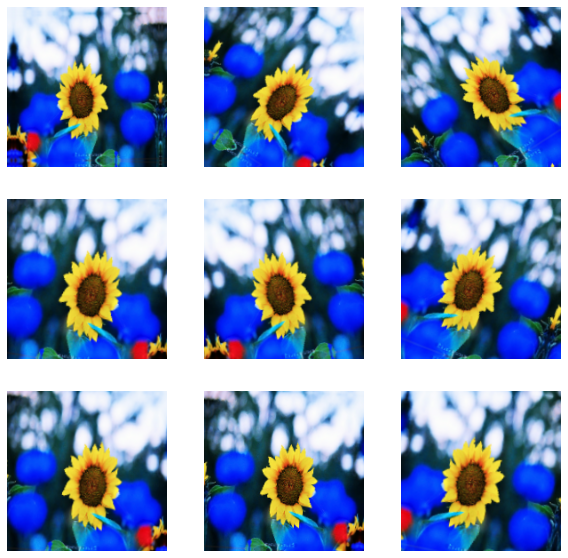

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

png

Vous utiliserez l'augmentation de données pour former un modèle dans un instant.

**Abandonner**

Une autre technique pour réduire le surajustement consiste à introduire une régularisation des abandons dans le réseau.

Lorsque vous appliquez une suppression à une couche, elle supprime de manière aléatoire (en définissant l'activation sur zéro) un certain nombre d'unités de sortie de la couche pendant le processus d'apprentissage. L'abandon prend un nombre fractionnaire comme valeur d'entrée, sous la forme de 0,1, 0,2, 0,4, etc. Cela signifie abandonner 10 %, 20 % ou 40 % des unités de sortie au hasard de la couche appliquée.

Créons un nouveau réseau de neurones avec tf.keras.layers.Dropout avant de l'entraîner à l'aide des images augmentées :

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compiler et entraîner le modèle**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


92/92 [==============================] - 138s 1s/step - loss: 1.3420 - accuracy: 0.4220 - val_loss: 1.1811 - val_accuracy: 0.5395
Epoch 2/15
92/92 [==============================] - 131s 1s/step - loss: 1.0012 - accuracy: 0.6087 - val_loss: 0.9472 - val_accuracy: 0.6376
Epoch 3/15
92/92 [==============================] - 130s 1s/step - loss: 0.8892 - accuracy: 0.6570 - val_loss: 0.8489 - val_accuracy: 0.6717
Epoch 4/15
92/92 [==============================] - 127s 1s/step - loss: 0.8135 - accuracy: 0.6928 - val_loss: 0.9787 - val_accuracy: 0.6526


KeyboardInterrupt: ignored

**Visualisez les résultats de l'entraînement**

Après avoir appliqué l'augmentation des données et tf.keras.layers.Dropout , il y a moins de surajustement qu'auparavant, et la précision de la formation et de la validation est plus proche :

ValueError: ignored

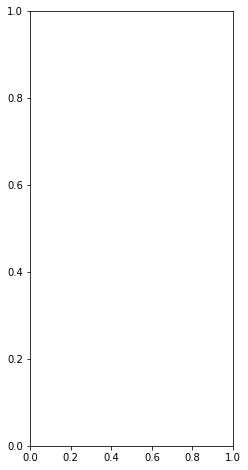

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Prédire sur de nouvelles données**

Enfin, utilisons notre modèle pour classer une image qui n'était pas incluse dans les ensembles d'apprentissage ou de validation.

Remarque : les couches d'augmentation et de suppression de données sont inactives au moment de l'inférence.

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)